# Are The Boston Celtics Better Than Random In Preventing Wide Open 3s?

![](pritesh-sudra-hG26UoUfU9s-unsplash.jpg)
<span>Photo by <a href="https://unsplash.com/@pritesh557?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Pritesh Sudra</a> on <a href="https://unsplash.com/s/photos/variance?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Every season around this point of the season,one or two fanbases are trying to convince themselves that opponents missing threes at an ungodly rate has something to do with their team&#39;s defense, when it&#39;s almost always variance at work.</p>&mdash; Anchorage Man (@SethPartnow) <a href="https://twitter.com/SethPartnow/status/1352643657745227783?ref_src=twsrc%5Etfw">January 22, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">I agree with <a href="https://twitter.com/SethPartnow?ref_src=twsrc%5Etfw">@SethPartnow</a> - opponent 3-point percentage on wide-open shots *should* be totally random. So why does it seem like the Celtics are always &quot;good&quot; at it? <a href="https://t.co/AI6qlu49fk">https://t.co/AI6qlu49fk</a> <a href="https://t.co/eoU6QXMAtu">pic.twitter.com/eoU6QXMAtu</a></p>&mdash; Todd Whitehead (@CrumpledJumper) <a href="https://twitter.com/CrumpledJumper/status/1352877690173317121?ref_src=twsrc%5Etfw">January 23, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

![](EsZjDl0VoAEEJYT.png)

Clearly, there are two implicit questions being raised here. The first is whether teams, and specifically, the Boston Celtics, have some control over how efficient their opponents are at shooting "wide open" 3s. The second question is, if teams do have some level control, how do they do it? I think it's important to address the first question, well, first, before speculating on any mechanism. I think the interesting "hedge" in Seth's statement about variance is "almost always". Anyway, let's examine this problem in some detail using [Pyro](http://pyro.ai/), Uber's probabilistic programming framework (ie let's put Bayes to work on this). As always the first thing we need to do is import a bunch of packages and libraries.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
from pyro import distributions as dist
import pyro.optim as optim
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import torch

I went to the NBA website and gathered the same dataset in Todd's tweet.

In [83]:
df = pd.read_csv('data/OPP_OPEN_3PT .csv')
df.head()

,YEAR,TEAM,FGM,FGA,FG2M,FG2A,FG3M,FG3A
0,2014,Washington Wizards,601,1406,286,545,315,861
1,2014,Utah Jazz,668,1502,297,591,371,911
2,2014,Toronto Raptors,563,1254,241,464,322,790
3,2014,San Antonio Spurs,482,1127,238,503,244,624
4,2014,Sacramento Kings,678,1484,300,557,378,927


Here I'm just adding a column that explicitly calculates the 3P%.

In [283]:
df['fg3pct'] = df.apply(lambda row: row['FG3M']/row['FG3A'], axis=1)
df.head()

,YEAR,TEAM,FGM,FGA,FG2M,FG2A,FG3M,FG3A,fg3pct
0,2014,Washington Wizards,601,1406,286,545,315,861,0.365854
1,2014,Utah Jazz,668,1502,297,591,371,911,0.407245
2,2014,Toronto Raptors,563,1254,241,464,322,790,0.407595
3,2014,San Antonio Spurs,482,1127,238,503,244,624,0.391026
4,2014,Sacramento Kings,678,1484,300,557,378,927,0.407767


And now we plot the same data as in the tweet, but in addition to showing the %'s, I made an additional heatmap that represents each season as a rank, which we will use later in the analysis.

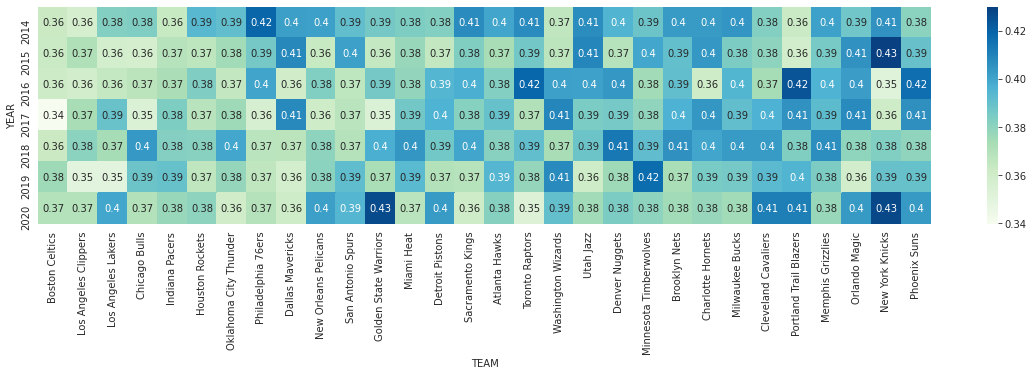

In [138]:
data = df.pivot('YEAR','TEAM','fg3pct')
ax = plt.figure(figsize=(20,4))
f = sns.heatmap(data.reindex(data.mean().sort_values().index,axis=1),annot=True,cmap="GnBu")

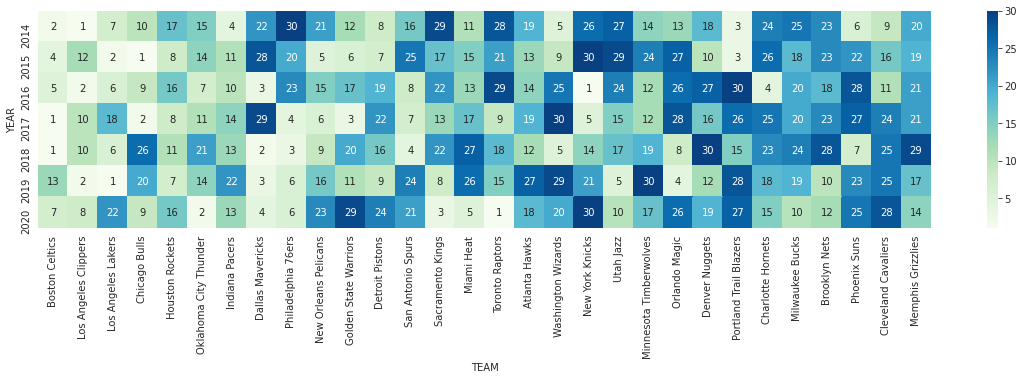

In [139]:
df['rank'] = df[['YEAR','TEAM','fg3pct']].groupby("YEAR").rank(ascending=True)
data = df.pivot('YEAR','TEAM','rank')
ax = plt.figure(figsize=(20,4))
g = sns.heatmap(data.reindex(data.mean().sort_values().index,axis=1),annot=True,cmap="GnBu")

# Single Parameter (aka 30 Teams Flipping One Coin)

The first model we'll want to study is the "default" or null hypothesis which is that team defense (according to opponent 3P%) on wide open 3pt shots is essentially a random process that is not actually dependent on the particular team. In this scenario, I am treating each team-season as a data point sampled according to the $Binomial$ distribution. The way I like to think about this is as a single coin being produced by a single mint being passed around from team to team to try their luck. Teams have no control over the parameters of the mint or the coin. The coin flip is determined by a parameter $\theta$ which itself is sampled from a $Beta$ prior. In terms of Pyro, it should be noted that parameters sampled outside of the `plate` (which basically acts as a for loop through the dataset) are considered *global*, whereas parameters sampled inside of the plate are *local*. So in this model it is clear that $\theta$ is a global parameter shared by every team, and we have no local parameters being inferred. Keep this in mind when we move to the next model.

In [37]:
def model(successes, trials):
    α = pyro.param("α", torch.tensor(1.))
    β = pyro.param("β", torch.tensor(1.))
    θ = pyro.sample("θ", dist.Beta(α, β))
    with pyro.plate("data", len(trials)):
        obs = pyro.sample("obs", dist.Binomial(total_count=trials, probs=θ), obs=successes)

As always, once we have the model defined, we then do the inference calculations, this time using the stochastic variational inference (SVI) class.

iteration 1: 2588.9811169991463
iteration 201: 1413.6529766658516
iteration 401: 1234.3783177176686
iteration 601: 996.6659791657896
iteration 801: 948.880579550025
iteration 1001: 936.1455495545836
iteration 1201: 968.8600810656519
iteration 1401: 975.6320441851587
iteration 1601: 925.7025679240198
iteration 1801: 1014.4433063456984


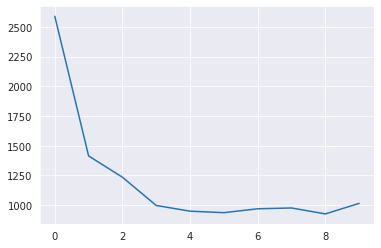

In [41]:
opt = optim.Adam({"lr":1e-3})
guide = AutoDiagonalNormal(model)
svi = SVI(model=model, guide=guide, optim=opt, loss=Trace_ELBO())
fg3m = torch.from_numpy(df.FG3M.to_numpy(dtype='float'))
fg3a = torch.from_numpy(df.FG3A.to_numpy('float'))

pyro.clear_param_store()
losses = []
loss = 0
epoch_loss = 0
iterations = 2000
for i in range(iterations):
    loss = svi.step(fg3m, fg3a)
    if i%(iterations/10)==0:
        losses.append(loss)
        print(f"iteration {i+1}: {loss}")
plt.plot(losses)

Here we are defining some code to sample from the posterior distribution.

In [42]:
guide.requires_grad_(False)

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("obs","θ","α","β"))
samples = predictive(fg3m, fg3a)
pred_summary = summary(samples)

And voila, we have some inferred values for the $Beta$ prior (which we aren't concerned with really), and a distribution for our $\theta$ parameter, which we are very much interested in.

In [43]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

α tensor(2.0401, requires_grad=True)
β tensor(2.6340, requires_grad=True)
AutoDiagonalNormal.loc Parameter containing:
tensor([-0.4759])
AutoDiagonalNormal.scale tensor([0.0485])


In [44]:
pred_summary['θ']

{'mean': tensor([0.3835]),
 'std': tensor([0.0116]),
 '5%': tensor([0.3656]),
 '95%': tensor([0.4032])}

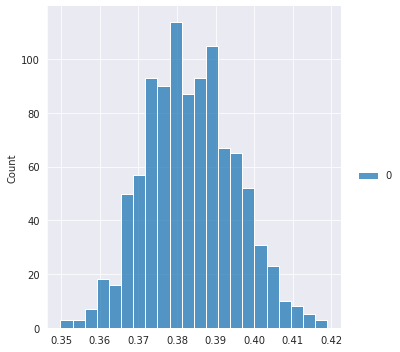

In [45]:
sns.displot(samples['θ'].numpy())

As you can see above with this model we get a distribution centered around 38.5% (as we would expect) with the middle 90% interval ranging from 36.5% to 40%. So how does our data compare to the model and how can we determine if the model actually "works"? My approach will be to look at a couple of test statistics calculated on both real and simulated data and see whether the model is consistent with the data. Specifically, below, we replicate the dataset 500 times by sampling the posterior for each number of attempts in the original dataset (eg if a team defended 300 shots in one season, we replicate that specific total). The two test statistics are the minimum average rank, $\overline{Rk3}_{min}$, and the minimum average 3P%, $\overline{Opp3}_{min}$. $\overline{Rk3}_{min}$ is calculated by ranking teams in each season according to opponent 3P% (1=best, 30=worst), subsequently averaging those ranks for each team over the 7 seasons, and then finding the minimum of the 30 averaged ranks. $\overline{Opp3}_{min}$ is minimum opponent 3P% after averaging for each team across the 7 seasons.


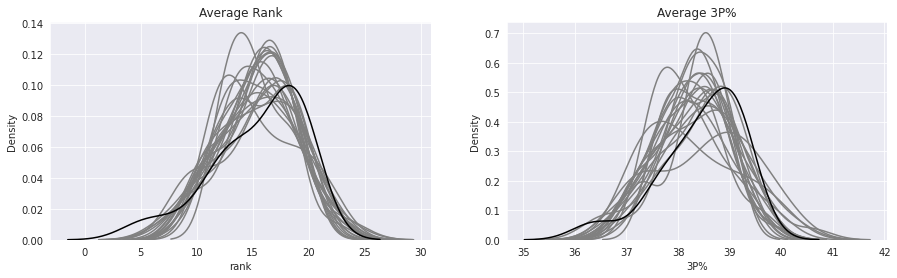

In [201]:
df['rank'] = df[['YEAR','TEAM','fg3pct']].groupby('YEAR').rank(ascending=True)
average_rank = df[['TEAM','YEAR','rank']].groupby('TEAM').mean('rank').sort_values("rank")
mean_3pct = 100*df[['YEAR','TEAM','fg3pct']].groupby('TEAM').mean()['fg3pct'].sort_values()
mean_3pct.head()
fig, ax = plt.subplots(1, 2,figsize=(15,4))
sns.set_style('darkgrid')
min_3pct = []
min_ranks = []
max_ranks = []
for i in range(500):
    sim_seasons = []
    for row in df.itertuples():
        sim_makes = dist.Binomial(row.FG3A, torch.from_numpy(guide.forward()['θ'].numpy())).sample()
        sim_seasons.append((row.YEAR, row.TEAM, row.FG3A, sim_makes.numpy(), 100*(sim_makes/row.FG3A).numpy()))
    sim_df = pd.DataFrame.from_records(sim_seasons,columns=['YEAR','TEAM','3PA','3PM','3P%'])
    sim_df['rank'] = sim_df[['YEAR','TEAM','3P%']].groupby("YEAR").rank(ascending=True)
    avg_sim_rank = sim_df[['TEAM','YEAR','rank']].groupby('TEAM').mean('rank').sort_values("rank")
    avg_sim_3pct = sim_df[['TEAM','YEAR','3P%']].groupby('TEAM').mean('3P%').sort_values("3P%")
    min_3pct.append(avg_sim_3pct['3P%'].min())
    min_ranks.append(avg_sim_rank['rank'].min())
    max_ranks.append(avg_sim_rank['rank'].max())
    if i%25==0:
        sns.kdeplot(data=avg_sim_rank['rank'],color='gray',ax=ax[0])
        sns.kdeplot(data=avg_sim_3pct['3P%'],color='gray',ax=ax[1])
g = sns.kdeplot(data=average_rank['rank'],alpha=1,color='black',ax=ax[0])
ax[0].set(title='Average Rank')
ax[1].set(title='Average 3P%')
g = sns.kdeplot(data=mean_3pct,alpha=1,color='black',ax=ax[1])

Above are plots showing the actual distribution of average rank and average 3P% overlaid on a sample of simulated distributions. Below we calculate the test statistics.

3P%: Number of simulations in tail = 24 (4.8%)
Ranks: Number of simulations in tail = 2 (0.4%)


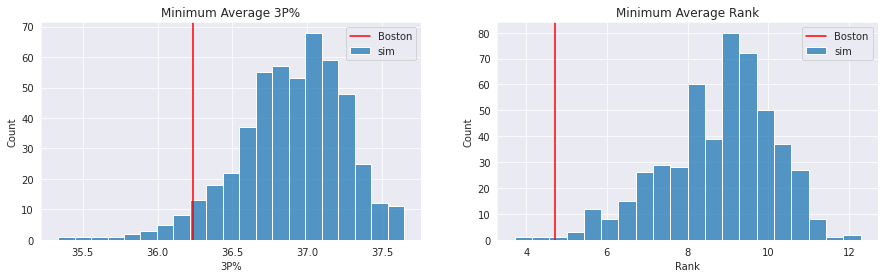

In [203]:
fig, ax = plt.subplots(1, 2,figsize=(15,4))
sns.histplot(min_3pct,label='sim',ax=ax[0])
ax[0].set(xlabel='3P%',title='Minimum Average 3P%')
ax[0].axvline(100*df.groupby('TEAM').mean()['fg3pct'].min(),color='red',label='Boston')
ax[0].legend()
freq = np.count_nonzero(np.array(min_3pct) < 100*df.groupby('TEAM').mean()['fg3pct'].min())
print(f"3P%: Number of simulations in tail = {freq} ({freq/5}%)")

sns.histplot(min_ranks,label='sim',ax=ax[1])
ax[1].set(xlabel='Rank',title='Minimum Average Rank')
ax[1].axvline(df.groupby('TEAM').mean()['rank'].min(),color='red',label='Boston')
ax[1].legend()
freq = np.count_nonzero(np.array(min_ranks) < df.groupby('TEAM').mean()['rank'].min())
print(f"Ranks: Number of simulations in tail = {freq} ({freq/5}%)")

Interestingly, $\overline{Opp3}_{min}$ is right at the margin of being plausible according to this simple model. However, $\overline{Rk3}_{min}$ appears to be clearly highly unlikely to have happened according to "normal" variance. So, it is probably fairly safe to say that something is going on with Boston's "Jedi" 3pt defense. Time for a more sophisticated model so we can try to capture a more realistic picture.

# Multiple Parameters (30 Coins From A Single Mint)

A step up in terms of model complexity is to assume each team has its own $\theta$ sampled from the same $Beta$ prior as before. Notice in the model below we have moved $\theta$ into the `plate` as it is now a *local* parameter (eg varies according to team). The $Beta$ parameters are still *global*.

In [206]:
def model(successes, trials):
    α = pyro.param("α", torch.tensor(1.))
    β = pyro.param("β", torch.tensor(1.))
    for i in pyro.plate("data", len(trials)):
        θ = pyro.sample(f"θ_{i}", dist.Beta(α, β))
        obs = pyro.sample(f"obs_{i}", dist.Binomial(total_count=torch.from_numpy(1.*trials[i]), probs=θ), obs=torch.from_numpy(1.*successes[i]))

To enable inference more easily in Pyro, I have reorganized the data into 30 rows with columns containing vectors of the opponent 3PT attempts and makes. There is nothing special about this, like I said, it just makes it easier to write the model.

In [207]:
fg3m_team = df.groupby('TEAM')['FG3M'].apply(np.array).reset_index()
fg3a_team = df.groupby('TEAM')['FG3A'].apply(np.array).reset_index()
data_teams = pd.merge(fg3m_team,fg3a_team,on='TEAM')
data_teams.head()

,TEAM,FG3M,FG3A
0,Atlanta Hawks,"[350, 377, 405, 518, 529, 605, 396]","[875, 1010, 1058, 1328, 1386, 1533, 1036]"
1,Boston Celtics,"[290, 329, 326, 375, 393, 528, 423]","[799, 906, 900, 1104, 1083, 1405, 1144]"
2,Brooklyn Nets,"[345, 379, 411, 448, 401, 480, 466]","[856, 970, 1051, 1130, 988, 1287, 1242]"
3,Charlotte Hornets,"[327, 344, 374, 553, 510, 557, 421]","[811, 851, 1036, 1367, 1275, 1445, 1114]"
4,Chicago Bulls,"[309, 271, 360, 433, 563, 532, 331]","[805, 758, 979, 1222, 1395, 1369, 894]"


For inference we're actually going to use MCMC instead of SVI. It turns out that the folks at Pyro have not yet implemented SVI for a *sequential plate*, at least, not in the automatic guides that are super easy to use. So in lieu of using SVI, we can just use the MCMC inference capabilities which are actually more accurate, if not as speedy.

In [214]:
from pyro.infer import NUTS, MCMC
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 500)
mcmc.run(data_teams.FG3M.to_numpy(), data_teams.FG3A.to_numpy())

Sample: 100%|██████████| 1000/1000 [03:09,  5.28it/s, step size=5.30e-01, acc. prob=0.889]


Here are the summary statistics where we can see real differences between teams. This is further demonstrated by looking at a sample of distributions below.

In [222]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       θ_0      0.39      0.01      0.39      0.38      0.39    716.60      1.00
       θ_1      0.36      0.01      0.36      0.35      0.37    959.69      1.00
       θ_2      0.39      0.01      0.39      0.38      0.40    905.08      1.00
       θ_3      0.39      0.01      0.39      0.38      0.40   1109.15      1.00
       θ_4      0.38      0.01      0.38      0.37      0.39   1121.15      1.00
       θ_5      0.39      0.01      0.39      0.38      0.40    940.19      1.00
       θ_6      0.38      0.01      0.38      0.37      0.39   1310.57      1.00
       θ_7      0.39      0.01      0.39      0.38      0.40   1102.08      1.00
       θ_8      0.38      0.01      0.39      0.37      0.39   1126.80      1.00
       θ_9      0.38      0.01      0.38      0.37      0.39   1114.41      1.00
      θ_10      0.38      0.01      0.38      0.37      0.39    709.18      1.00
      θ_11      0.38      0

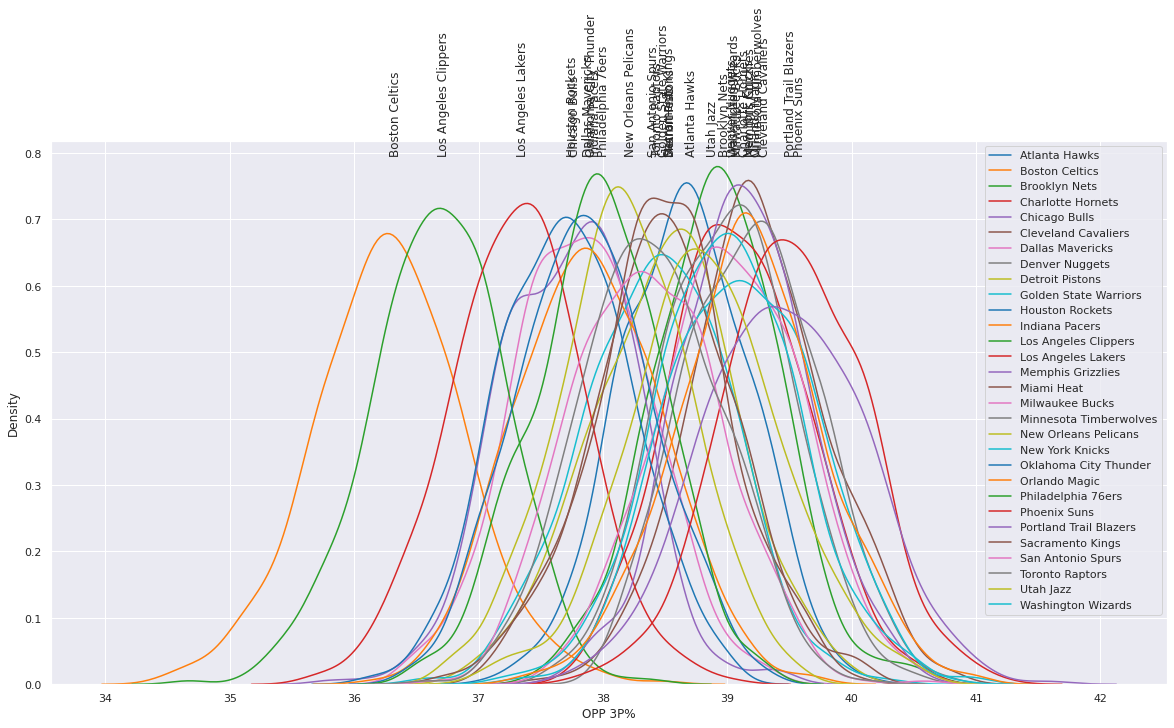

In [220]:
posterior = mcmc.get_samples()
plt.figure(figsize=(20,10))
sns.set_context('notebook')
teams = data_teams['TEAM']
for ind,team in teams.items():
    f = sns.kdeplot(100.0*posterior[f'θ_{ind}'],label=team)
    f.legend()
    f.text(100.0*posterior[f'θ_{ind}'].mean(),0.8, team,horizontalalignment='left',rotation=90)
g = plt.xlabel('OPP 3P%')

Now, let's repeat the calculation of test statistics using the multiparameter model and see if it's more consistent with real data.

In [278]:
min_3pct = []
min_ranks = []
max_ranks = []
team_dict = {team:idx for idx, team in teams.iteritems()}
for i in range(500):
    sim_seasons = []
    season_sample = mcmc.get_samples(1)
    for row in df.itertuples():
        θ_team = season_sample[f'θ_{team_dict[row.TEAM]}']
        sim_makes = dist.Binomial(row.FG3A, θ_team).sample().squeeze()
        sim_seasons.append((row.YEAR, row.TEAM, row.FG3A, sim_makes.numpy(), 100*(sim_makes/row.FG3A).numpy()))
    sim_df = pd.DataFrame.from_records(sim_seasons,columns=['YEAR','TEAM','3PA','3PM','3P%'])
    sim_df['rank'] = sim_df[['YEAR','TEAM','3P%']].groupby("YEAR").rank(ascending=True)
    avg_sim_rank = sim_df[['TEAM','YEAR','rank']].groupby('TEAM').mean('rank').sort_values("rank")
    avg_sim_3pct = sim_df[['TEAM','YEAR','3P%']].groupby('TEAM').mean('3P%').sort_values("3P%")
    min_3pct.append(avg_sim_3pct['3P%'].min())
    min_ranks.append(avg_sim_rank['rank'].min())
    max_ranks.append(avg_sim_rank['rank'].max())

3P%: Number of simulations in tail = 356 (71.2%)
Ranks: Number of simulations in tail = 307 (61.4%)


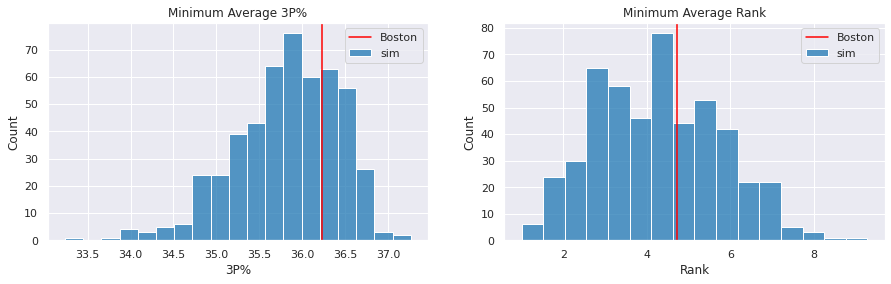

In [279]:
fig, ax = plt.subplots(1, 2,figsize=(15,4))
sns.histplot(min_3pct,label='sim',ax=ax[0])
ax[0].set(xlabel='3P%',title='Minimum Average 3P%')
ax[0].axvline(100*df.groupby('TEAM').mean()['fg3pct'].min(),color='red',label='Boston')
ax[0].legend()
freq = np.count_nonzero(np.array(min_3pct) < 100*df.groupby('TEAM').mean()['fg3pct'].min())
print(f"3P%: Number of simulations in tail = {freq} ({freq/5}%)")

sns.histplot(min_ranks,label='sim',ax=ax[1])
ax[1].set(xlabel='Rank',title='Minimum Average Rank')
ax[1].axvline(df.groupby('TEAM').mean()['rank'].min(),color='red',label='Boston')
ax[1].legend()
freq = np.count_nonzero(np.array(min_ranks) < df.groupby('TEAM').mean()['rank'].min())
print(f"Ranks: Number of simulations in tail = {freq} ({freq/5}%)")

![](https://media4.giphy.com/media/RihN3OGqAiiW3o0Hl0/giphy.gif?cid=6c09b952ff923064877c1242780f181fbd4955852fb00fdc&rid=giphy.gif)

Sweet! So it looks like the data is consistent with this second slightly more complex model. Of course, we could try to add complexity (for example, year-to-year correlation), but given this smallish dataset, my guess is it wouldn't bear much fruit and be difficult to show meaningful improvement. Feel free to give it a whirl though! Now it's time to circle back around to the second question posed in the very beginning of this post. What is the cause of this? I will leave that for smarter basketball people than me to speculate. 

## If you enjoyed this post please leave a Github star and share!